In [10]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import random
from numba import jit
import pickle

from psiam_tied_dv_map_utils import up_RTs_fit_fn, down_RTs_fit_fn, psiam_tied_data_gen_wrapper
from psiam_tied_utils import  all_RTs_fit_fn


# params

In [11]:
# stim params
ABL_arr = [20]
ILD_arr = [0]


# Model params
rate_lambda = 0.076
theta_E = 50.7
T_0 = 0.19*(1e-3)

V_A = 0.5
theta_A = 1

t_stim = 0.25
t_A_aff = 0.02
t_E_aff = 0.03
t_motor = 0.04
Z_E = 5

# DV map
L = 1

# sim params
N_sim = int(1e6)
dt = 1e-4

# fitting params
K_max = 10

# generate or read data

In [12]:
# with open('sim_results_e_8.pkl', 'rb') as f:
#     sim_results = pickle.load(f)

sim_results = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                        rate_lambda, T_0, theta_E, Z_E, \
                                                                            t_stim, t_A_aff, t_E_aff, t_motor, L, dt)\
                                                                                  for _ in range(N_sim))
# parse results
all_choice = np.array([res['choice'] for res in sim_results])
all_RT = np.array([res['rt'] for res in sim_results])
all_is_act = np.array([res['is_act'] for res in sim_results])


print(f"% of AI process = {100*np.sum(all_is_act)/N_sim}")
print(f"Num of Aborts = {np.sum(all_RT < t_stim)}")
print(f"Num of up hits = {np.sum(all_choice == 1)}, Num of down hits = {np.sum(all_choice == -1)}")

% of AI process = 21.5964
Num of Aborts = 33779
Num of up hits = 551765, Num of down hits = 448235


# fit all RT

In [13]:
# stim
ABL = ABL_arr[0]; ILD = ILD_arr[0]

# bins
bin_width = 0.001  
bins = np.arange(min(all_RT), max(all_RT) + bin_width, bin_width)

# t_pts are midpoints of the bins
t_pts = bins[:-1] + bin_width/2
theory = all_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

all_hist, all_bins = np.histogram(all_RT, bins=bins, density=True)

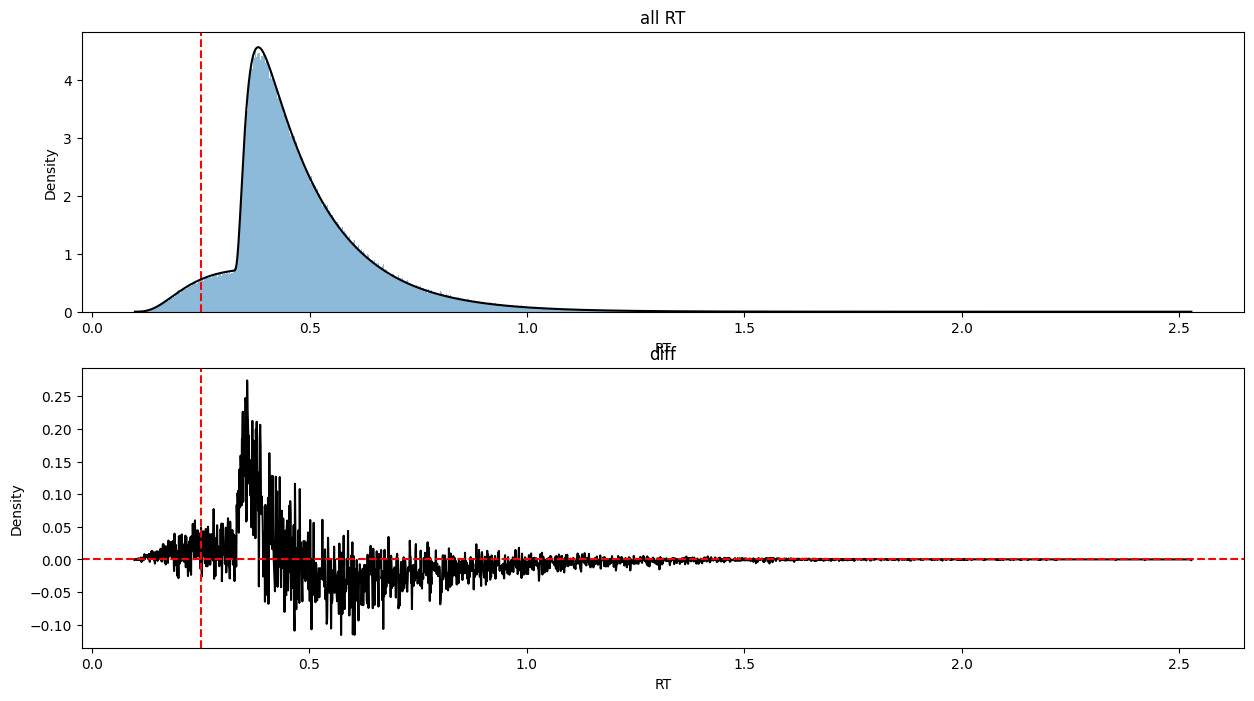

In [14]:
plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(all_bins[:-1], all_hist, width=bin_width, alpha=0.5, label='all RT')
plt.axvline(x=t_stim, color='r', linestyle='--')
plt.plot(t_pts, theory, 'k');
plt.title('all RT');plt.xlabel('RT');plt.ylabel('Density');

plt.subplot(2,1,2)
diff_all = theory - all_hist 
plt.plot(t_pts, diff_all, 'k');
plt.title('diff');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--');


# fit up RT

In [15]:
up_rt_idx = np.where(all_choice == 1)[0]
up_rt = all_RT[up_rt_idx]

non_abort_up_rt_idx = np.where(up_rt > t_stim)[0]
up_rt = up_rt[non_abort_up_rt_idx]

bin_width = 0.001
min_rt = np.min(up_rt)
max_rt = np.max(up_rt)

# hist
bins = np.arange(min_rt, max_rt + bin_width, bin_width)
up_hist, up_bins = np.histogram(up_rt, bins=bins, density=True)
up_hist *= len(up_rt)/( len(all_RT) )

# theory
t_pts = bins[:-1] + bin_width/2
ABL = ABL_arr[0]; ILD = ILD_arr[0]
up_theory = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L,  K_max)

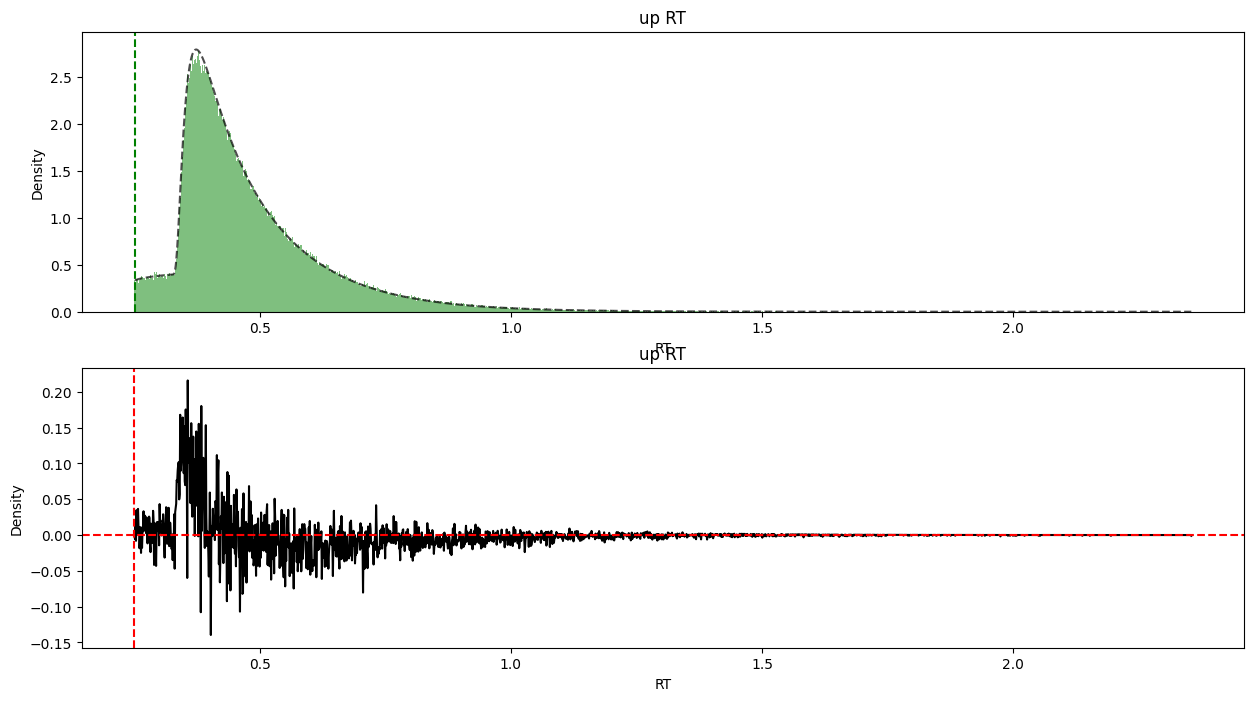

In [16]:
plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(up_bins[:-1], up_hist, width=bin_width, color='g', alpha=0.5)
plt.axvline(x=t_stim, color='g', linestyle='--')
plt.plot(t_pts, up_theory, linestyle='--', color='k', alpha=0.7);
plt.xlabel('RT');plt.ylabel('Density');plt.title('up RT');

plt.subplot(2,1,2)
diff_up = up_theory - up_hist
plt.plot(t_pts, diff_up, 'k');
plt.title('up RT');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--');

# fit down RT

In [17]:
down_rt_idx = np.where(all_choice == -1)[0]
down_rt = all_RT[down_rt_idx]

non_abort_down_rt_idx = np.where(down_rt > t_stim)[0]
down_rt = down_rt[non_abort_down_rt_idx]

ABL = ABL_arr[0]; ILD = ILD_arr[0]


bin_width = 0.001
min_rt = np.min(down_rt)
max_rt = np.max(down_rt)
bins = np.arange(min_rt, max_rt + bin_width, bin_width)

down_hist, down_bins = np.histogram(down_rt, bins=bins, density=True)
down_hist *= len(down_rt)/( len(all_RT))


t_pts = bins[:-1] + bin_width/2
down_theory = down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)

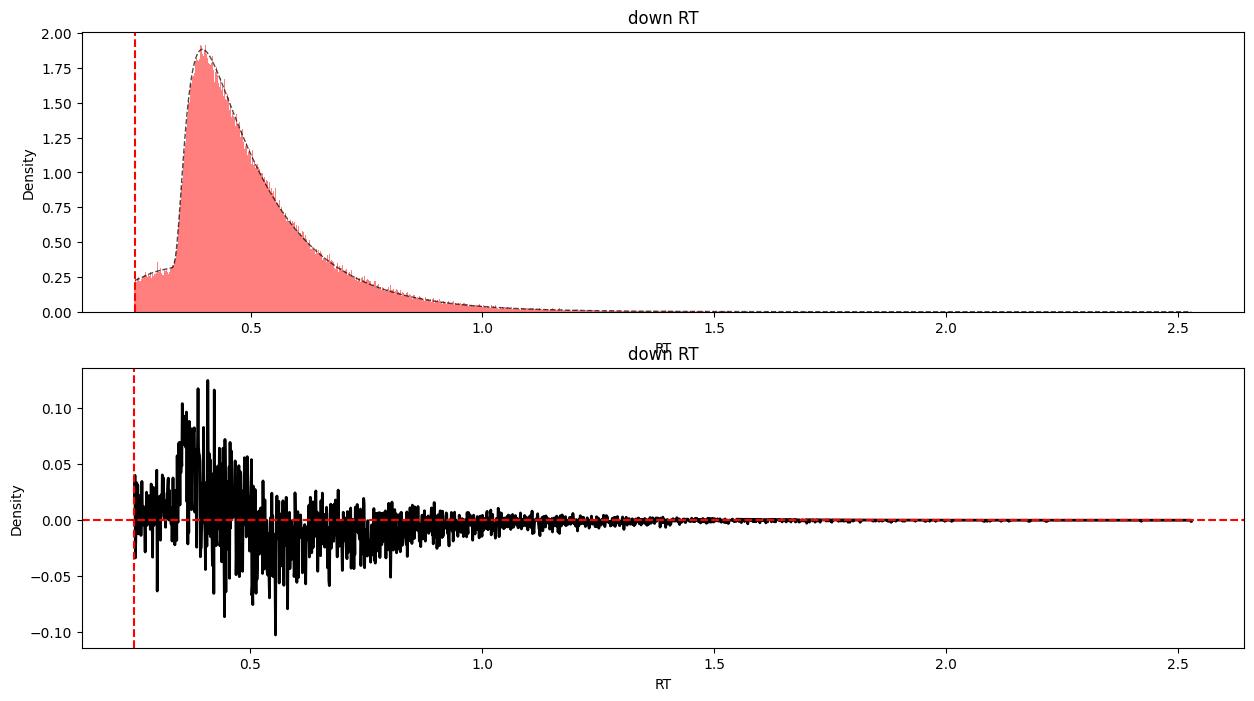

In [18]:
plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(down_bins[:-1], down_hist, width=bin_width, color='r', alpha=0.5)
plt.axvline(x=t_stim, color='r', linestyle='--')
plt.plot(t_pts, down_theory, 'k', lw=1, linestyle='--', alpha=0.7);
plt.xlabel('RT');plt.ylabel('Density');plt.title('down RT');

plt.subplot(2,1,2)
diff_down = down_theory - down_hist
plt.plot(t_pts, diff_down, 'k', lw=2);
plt.title('down RT');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--') 
plt.xlabel('RT');plt.ylabel('Density');plt.title('down RT');
